In [1]:
import warnings

warnings.filterwarnings("ignore")

from typing import List, Optional, Union

import numpy as np
import pandas as pd

from tsururu.dataset import IndexSlicer, Pipeline, TSDataset
from tsururu.models.boost import CatBoost
from tsururu.models.stats import ETS, ARIMA, Theta
from tsururu.model_training.validator import KFoldCrossValidator
from tsururu.model_training.trainer import StatTrainer, MLTrainer
from tsururu.strategies import (
    DirectStrategy,
    FlatWideMIMOStrategy,
    MIMOStrategy,
    RecursiveStrategy,
    StatStrategy,
)
from tsururu.transformers import (
    DateSeasonsGenerator,
    DifferenceNormalizer,
    LagTransformer,
    LastKnownNormalizer,
    SequentialTransformer,
    StandardScalerTransformer,
    TargetGenerator,
    UnionTransformer,
)

In [2]:
def get_results(
    cv: int,
    regime: str,
    y_true: Optional[List[np.ndarray]] = None,
    y_pred: Optional[List[np.ndarray]] = None,
    ids: Optional[List[Union[float, str]]] = None,
) -> pd.DataFrame:
    def _get_fold_value(
        value: Optional[Union[float, np.ndarray]], idx: int
    ) -> List[Optional[Union[float, np.ndarray]]]:
        if value is None:
            return [None]
        if isinstance(value[idx], float):
            return value[idx]
        if isinstance(value[idx], np.ndarray):
            return value[idx].reshape(-1)
        raise TypeError(f"Unexpected value type. Value: {value}")

    df_res_dict = {}

    for idx_fold in range(cv):
        # Fill df_res_dict
        for name, value in [("y_true", y_true), ("y_pred", y_pred)]:
            df_res_dict[f"{name}_{idx_fold+1}"] = _get_fold_value(
                value, idx_fold
            )
        if regime != "local":
            df_res_dict[f"id_{idx_fold+1}"] = _get_fold_value(ids, idx_fold)

    # Save datasets to specified directory
    df_res = pd.DataFrame(df_res_dict)
    return df_res

There are several main objects to look out for when working with the library:
1) `TSDataset`.
2) `Pipeline` and `Transformers`
3) `Strategy`.
4) `Model`.

### TSDataset

This class is needed to store data and meta-information about it.

To initialise it is necessary to submit the data in `pd.DataFrame` format and define some meta-information about roles that necessary for solving the task of time series forecasting: `id`, `date`, `target`.

In [3]:
df_path = "datasets/global/train_kaggle.csv"
train_df = pd.read_csv(df_path, sep=",")
train_df.sample(5)

,Store_id,SKU_id,Date,Promo,Demand,Regular_Price,Promo_Price
1099,3,1,25.03.2015,NaN,226,140.67,NaN
70247,53,2,09.04.2015,NaN,6,146.38,NaN
27946,56,1,07.01.2015,NaN,44,168.67,NaN
51492,16,2,20.05.2015,NaN,0,146.38,NaN
19536,39,1,21.08.2015,NaN,408,142.85,NaN


In [4]:
train_df["Date"] = pd.to_datetime(train_df['Date'], dayfirst=True, format="mixed")
train_df["id"] = train_df["Store_id"].astype("str") + "_" + train_df["SKU_id"].astype("str") 

In [5]:
dataset_params = {
    "target": {
        "columns": ["Demand"],
        "type": "continious",
    },
    "date": {
        "columns": ["Date"],
        "type": "datetime",
    },
    "id": {
        "columns": ["id"],
        "type": "categorical",
    }
}

In [6]:
dataset = TSDataset(
    data=train_df,
    columns_params=dataset_params,
    print_freq_period_info=True,
)

freq: Day; period: 1


### Pipeline and Transformers

#### What kind of transformers are there?

Special attention should be paid to the `Transformer` class: the elements of the pipeline that are responsible for transforming the values of a series and generating features. `Pipeline` class is a wrapper over transformers which is needed to provide some additional methods and functions above them.

There are two types of transformers that are used to collect pipelines:
- `Union` transformers;
- `Sequential` transformers.

Below is a list of available Transformers: 
- `StandardScalerTransformer` *(Series4Series)*.
- `DifferenceNormalizer` *(Series4Series)*: subtract the previous value or divide by it.
- `LastKnownNormalizer` *(Features4Features)*: normalize all lags by the last known one: divide by it or subtract.

This three transformers provide flags `transform_features` / `transform_target`, that allow you to manipulate traits and targets separately and get different results from them.

Besides, __DifferenceNormalizer__ and __LastKnownNormalizer__ can be applied in two regimes: `delta` and `ratio`: in the first case, normalisation means subtracting the target value from the current value, and in the second, dividing by it.

- `LabelEncodingTransformer` and `OneHotEncodingTransformer` *(Series4Series)* - encoders for categorical features.
- `TimeToNumGenerator` and `DateSeasonsGenerator` *(Series4Series)* - generator for seasonal features by dates.
- `LagTransformer` *(Series4Features) - generator for lags. 

__!!!The lag transformer must necessarily be present in the sequential transformer, otherwise the features will not be generated.!!!__

Finally, to generate targets, you need to use `TargetGenerator`.

#### Transformers must be assembled in order!

The __SeriesToSeries__ transformers should come first, followed by the LagTransformer and TargetGenerator (__SeriesToFeatures__), and then the __FeaturesToFeatures__ transformers.

!!!Thus, `StandardScalerNormalizer` and `DifferenceNormalizer` should be before `LagTransformer` and `LastKnownNormalizer` after it!!!

#### How to build a Pipeline?

So, there are two ways to build a pipline from transformers: initialise the transformers of interest by hand or use a config in the form of a dictionary. Let's look at both ways.

In [7]:
# standard_scaler = StandardScalerTransformer(
#     transform_features=True,
#     transform_target=True
# )

# lag = LagTransformer(lags=3)
# date_lag = LagTransformer(lags=3)
# id_lag = LagTransformer(lags=1)

# target_generator = TargetGenerator()

# date_seasons = DateSeasonsGenerator(
#     seasonalities=["doy", "m", "wd"],
#     from_target_date=True,
# )

In [8]:
standard_scaler = StandardScalerTransformer(
    transform_features=True,
    transform_target=True
)

seq_1 = SequentialTransformer(transformers_list=[standard_scaler], input_features=["Demand"])

union = UnionTransformer(transformers_list=[seq_1])

In [9]:
# union_1 = UnionTransformer(transformers_list=[lag, target_generator])

# seq_1 = SequentialTransformer(transformers_list=[standard_scaler, union_1], input_features=["value"])
# seq_2 = SequentialTransformer(transformers_list=[date_seasons, date_lag], input_features=["date"])
# seq_3 = SequentialTransformer(transformers_list=[id_lag], input_features=["id"])

# union = UnionTransformer(transformers_list=[seq_1, seq_2, seq_3])

In [10]:
pipeline_1 = Pipeline(union, multivariate=False)

In [11]:
pipeline_1.__dict__

{'transformers': <tsururu.transformers.base.UnionTransformer at 0x1f434e1d690>,
 'multivariate': False,
 'is_fitted': False,
 'strategy_name': None,
 'output_features': None,
 'y_original_shape': None}

Or:

In [12]:
# pipeline_params = {
#     "target": {
#         "columns": ["value"],
#         "features": {
#             "StandardScalerTransformer":
#                 {
#                     "transform_target": True, 
#                     "transform_features": True
#                 },
#             "LagTransformer": {"lags": 7},
#         },
#     },
#     "date": {
#         "columns": ["date"],
#         "features": {
#             "DateSeasonsGenerator": {
#                 # Use seasonality features from the date column as 
#                 # features with datetime lags
#                 # Possible values: [
#                 #    "y": year, "m": month, "d": day, 
#                 #    "wd": weekday, "doy": dayofyear,
#                 #    "hour": hour, "min": minute, "sec": second, 
#                 #    "ms": microsecond,  "ns": nanosecond
#                 # ]
#                 "seasonalities": ['doy', 'm', 'wd'], 
#                 # Use date from target point to make datetime features
#                 "from_target_date": True,
#             },
#             "LagTransformer": {"lags": 3}
#         },
#     },
#     "id": {
#         "columns": ["id"],
#         "features": {
#             "LagTransformer": {"lags": 1},
#         },
#     }
# }

In [13]:
#pipeline = Pipeline.from_dict(pipeline_params, multivariate=False)

Or:

In [14]:
# pipeline_easy_params = {
#     # One from ["none", "standard_scaler", "difference_normalizer", "last_known_normalizer"]
#     "target_normalizer": "standard_scaler",

#     # One from ["none", "delta", "ratio"]  (MUST BE "none" for "standard_scaler" and NOT "none" for others)
#     "normalizer_regime": "none",

#     # One from ["features", "target", "features_target"]
#     "normalizer_transform_regime": "features_target",

#     "target_lags": 3,
#     "date_lags": 1,
# #    "exog_lags": 1,
# }

In [15]:
#pipeline = Pipeline.easy_setup(dataset_params, pipeline_easy_params, multivariate=False)

#### Can I use exogenous variables in the pipeline?

Yes! Exogenous variables can also be specified here. Just include them in your pipeline.

However, their operation is currently tested only for the `MIMOStrategy` in global-modelling. For other strategies support of additional variables is under development.

In [16]:
# pipeline_params["exog_group_1"] = {
#     "columns": ["value"],
#     "features": {
#         "StandardScalerTransformer":
#             {
#                 "transform_target": False, 
#                 "transform_features": True
#             },
#         "LagTransformer": {"lags": 7},
#     },
# }

__Make sure you have the transform_target = False flag for exogenous features!__

#### Model, Validator and Trainer

- `Model`:
  - The model is separate from the strategy. Any model can be run in any strategy if it supports this input and output format.
  - You can use on of the implemented ML models (for instance, GBM (Gradient Boosting Machine)).
- `Validator`:
  - The validator is responsible for setting up the validation process, which includes creating training and validation folds. It ensures that the data is split correctly so that the model’s performance can be accurately assessed. 
- `Trainer`:
  - The trainer is the component that trains the model with provided validator. 
  - It is necessary to choose a trainer in accordance with the type of model (ML, DL, stats).

In [17]:
# # Configure the model parameters
# model = CatBoost
# model_params = {
#     "loss_function": "MultiRMSE",
#     "early_stopping_rounds": 100,
#     "verbose": 500,
# }

# # Configure the validation parameters
# validation = KFoldCrossValidator
# validation_params = {
#     "n_splits": 2,
# }

# trainer_params = {}

# trainer = MLTrainer(
#     model,
#     model_params,
#     validation,
#     validation_params,
# )

In [18]:
model_class = ETS

ets_params = {
    'model': ['Z', 'Z', 'Z'],
    'season_length': 7,
    'damped': None,
    'phi': None
}

horizon = 7
history = 7
step = 1

In [19]:
stat_trainer = StatTrainer(model_class, ets_params, 'D', dataset.id_column, dataset.date_column)

In [20]:
stat_strategy = StatStrategy(horizon, history, step, stat_trainer, pipeline_1)

In [21]:
stat_fit_time, _ = stat_strategy.fit(dataset)

In [22]:
from statsforecast.utils import AirPassengersDF as ap
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA, AutoETS, AutoTheta, AutoCES

sf = StatsForecast(
    models=[AutoETS(season_length=7, model=['Z', 'Z', 'Z'])], # models for forecasting
    freq='D',  # frequency of the data
    n_jobs=3  # number of jobs to run in parallel, -1 means using all processors
)

In [23]:
mod=sf.fit(train_df, id_col='id', time_col='Date', target_col='Demand')

In [24]:
forecast_st = sf.predict(h=7)
forecast_st.AutoETS.tolist()

[674.8681030273438,
 736.73828125,
 798.6085205078125,
 860.478759765625,
 922.3489990234375,
 984.2191772460938,
 1046.0894775390625,
 1.9805947542190552,
 1.9805947542190552,
 1.9805947542190552,
 1.9805947542190552,
 1.9805947542190552,
 1.9805947542190552,
 1.9805947542190552,
 531.503173828125,
 531.503173828125,
 531.503173828125,
 531.503173828125,
 531.503173828125,
 531.503173828125,
 531.503173828125,
 4.30343770980835,
 4.30343770980835,
 4.30343770980835,
 4.30343770980835,
 4.30343770980835,
 4.30343770980835,
 4.30343770980835,
 157.80078125,
 306.3905029296875,
 319.3298034667969,
 286.28857421875,
 257.20220947265625,
 209.510986328125,
 169.9236602783203,
 1.3769659996032715,
 1.3769659996032715,
 1.3769659996032715,
 1.3769659996032715,
 1.3769659996032715,
 1.3769659996032715,
 1.3769659996032715,
 290.5097351074219,
 1862.0201416015625,
 1278.9375,
 954.3345336914062,
 900.639892578125,
 860.8074951171875,
 651.2091674804688,
 0.00030009998590685427,
 0.000300099985

In [25]:
_, forecast = stat_strategy.predict(dataset)

In [26]:
forecast.Demand.tolist()

[674.8710530687963,
 736.744272997499,
 798.6174929262016,
 860.4907128549044,
 922.363932783607,
 984.2371527123097,
 1046.1103726410124,
 1.9791421751053662,
 1.9791421751053662,
 1.9791421751053662,
 1.9791421751053662,
 1.9791421751053662,
 1.9791421751053662,
 1.9791421751053662,
 518.0063015467786,
 518.0063015467786,
 518.0063015467786,
 518.0063015467786,
 518.0063015467786,
 518.0063015467786,
 518.0063015467786,
 4.302787976627284,
 4.302787976627284,
 4.302787976627284,
 4.302787976627284,
 4.302787976627284,
 4.302787976627284,
 4.302787976627284,
 175.4651785653445,
 170.9687288890148,
 167.37155949811833,
 164.49381606758965,
 162.19161587967133,
 160.34985065698868,
 158.87643486015526,
 1.3746284286592072,
 1.3746284286592072,
 1.3746284286592072,
 1.3746284286592072,
 1.3746284286592072,
 1.3746284286592072,
 1.3746284286592072,
 566.8011631909696,
 566.8011631909696,
 566.8011631909696,
 566.8011631909696,
 566.8011631909696,
 566.8011631909696,
 566.8011631909696,
 0

In [62]:
compr = pd.DataFrame({'AutoETS': forecast_st.AutoETS.tolist(), 'tsururu': forecast.Demand.tolist(), 'Date': forecast.Date, 'ts_id': forecast.id})
compr['diffr'] = (compr.AutoETS-compr.tsururu).astype(float)

In [67]:
diff_eps = 20

In [70]:
big_diff = compr[(compr.diffr>diff_eps) | (compr.diffr<-diff_eps)]
big_diff.sort_values(by='diffr')

,AutoETS,tsururu,Date,ts_id,diffr
630,1446.780273,2108.517375,2016-05-23,48_1,-661.737101
784,1297.481323,1869.191253,2016-05-23,58_1,-571.709930
420,1704.195435,2184.753091,2016-05-23,34_1,-480.557656
602,1034.883545,1419.511883,2016-05-23,46_1,-384.628338
1288,364.833679,745.022915,2016-05-23,90_1,-380.189236
...,...,...,...,...,...
491,3979.483887,1409.725291,2016-05-24,39_1,2569.758596
632,5931.847168,2490.669284,2016-05-25,48_1,3441.177884
659,5231.432617,1377.479297,2016-05-24,4_1,3853.953320
267,6910.068848,1991.623688,2016-05-24,24_1,4918.445160


In [92]:
etstest=big_diff[big_diff.ts_id=='48_1']
etstest

,AutoETS,tsururu,Date,ts_id,diffr
630,1446.780273,2108.517375,2016-05-23,48_1,-661.737101
631,8779.084961,2623.025182,2016-05-24,48_1,6156.059779
632,5931.847168,2490.669284,2016-05-25,48_1,3441.177884
633,3114.662109,2263.095417,2016-05-26,48_1,851.566693
634,2837.576172,2217.948361,2016-05-27,48_1,619.627811
635,3246.853516,2281.579256,2016-05-28,48_1,965.274259
636,1903.153320,2129.603290,2016-05-29,48_1,-226.449970


In [81]:
dftest = train_df[train_df.id=='48_1']

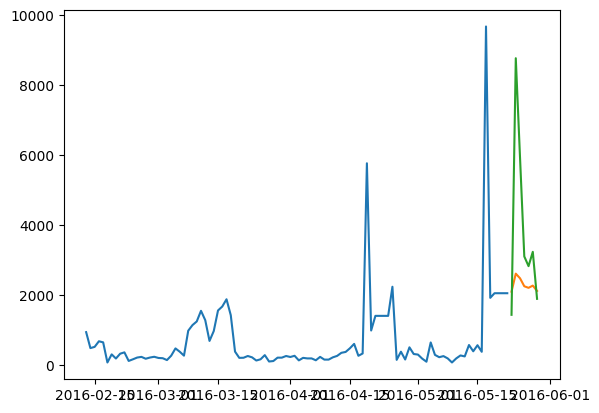

In [91]:
import matplotlib.pyplot as plt

plt.plot(dftest.Date[-100:], dftest.Demand[-100:])
plt.plot(forecast_test.Date, forecast_test.Demand)
plt.plot(etstest.Date, etstest.AutoETS)

In [79]:
forecast_test = forecast[forecast.id=='48_1']

In [69]:
sorted(big_diff.diffr.tolist())

[-661.7371013547645,
 -571.7099296562528,
 -480.5576561506323,
 -384.62833828677276,
 -380.1892360001211,
 -370.9988181642216,
 -352.5946887736643,
 -336.9340400057549,
 -336.698868698297,
 -321.040026782802,
 -305.8508120952424,
 -293.84185654277485,
 -290.8919663881602,
 -290.7681168409481,
 -279.93281586010016,
 -279.62129927953447,
 -278.412532758231,
 -276.29142808354777,
 -272.6831184693399,
 -255.12239857630857,
 -246.8142734271305,
 -242.78780033094995,
 -230.2526202425595,
 -226.44996986996966,
 -221.84277152932748,
 -214.16171240420408,
 -212.9824771514186,
 -209.26232074448467,
 -209.02758354781872,
 -198.50247274444587,
 -198.2367219721756,
 -195.79410528401627,
 -190.67555726800697,
 -185.49223300779624,
 -178.56801538747686,
 -171.8749627999698,
 -167.97098753860928,
 -167.01913014230854,
 -162.9103518200136,
 -151.81087076067047,
 -146.3491715284481,
 -141.78167533792123,
 -139.9861843773101,
 -139.85045065508507,
 -137.84968912004547,
 -133.4187825304366,
 -132.03372635

#### Strategy

- _Recursive:_ 
    - one model for all points of the forecast horizon;
    - *training*: the model is trained to predict one point ahead;
    - *prediction*: a prediction is iteratively made one point ahead, and then this prediction is used to further shape the features in the test data. 
- _Recursive-reduced:_
    - one model for all points in the prediction horizon;
    - *training*: the model is trained to predict one point ahead;
    - *prediction*: features are generated for all test observations at once, unavailable values are replaced by NaN.
- _Direct:_ 
    - individual models for each point in the prediction horizon. 
- _MultiOutput (MIMO - Multi-input-multi-output):_
    - one model that learns to predict the entire prediction horizon. 
    - __Also, this strategy supports the presence of `exogenous features` (only for local- or global-modelling).__
- _FlatWideMIMO:_.
    - mixture of Direct and MIMO, fit one model, but uses deployed over horizon Direct's features.
    - __Number of `lags for datetime features` should be equal to `horizon` while using this strategy.__

In [27]:
horizon = 3
history = 7
step = 1

In [28]:
#strategy = RecursiveStrategy(horizon, history, step, trainer, pipeline)

In [29]:
#fit_time, _ = strategy.fit(dataset)

In [30]:
#forecast_time, current_pred = strategy.predict(dataset)

In [31]:
#current_pred

## Backtest validation of pipeline

In [32]:
#ids, test, pred, fit_time, forecast_time = strategy.back_test(dataset, cv=1)

In [33]:
#get_results(cv=1, regime="global", y_true=test, y_pred=pred, ids=ids)

## Working with raw time series' granularity

Time series come in different granularities, from hourly and daily time series to more complex ones such as the end of each quarter.

If the rows do not contain segments that are too short (that are shorter than history + horizon), then `tsururu` will try to extract the row granularity on its own. We currently support the following types:

- Yearly (and YearlyEnd)
- Quarterly (and Quarterly)
- Monthly (and MonthlyEnd)
- Weekly
- Daily
- Hourly
- Minlutely
- Secondly
- Microsecondly

There is also support for compound granularities (10 days, 15 minutes, 32 seconds, etc.). The correctness of the selected granularity can be checked from the output after the `Dataset` class has been created.

However, there are tricky situations (e.g. 28 days) where the monthly granularity may be guessed incorrectly. Therefore, it is possible to set your own granularity using the `pd.DateOffset` class or related classes from `pandas.tseries.offsets`, which must be fed as `delta` parameter into the `Dataset` class. Then the time column will be processed according to the user's settings.

Consider a time series where each point is exactly __28 daily points away__ from each other

In [34]:
# df_path_2 = "datasets/global/simulated_data_to_check_28D.csv"

# # Configure the features settings
# dataset_params_2 = {
#     "target": {
#         "columns": ["value"],
#         "type": "continious",
#     },
#     "date": {
#         "columns": ["date"],
#         "type": "datetime",
#     },
#     "id": {
#         "columns": ["id"],
#         "type": "categorical",
#     }
# }

In [35]:
# dataset_2 = TSDataset(
#     data=pd.read_csv(df_path_2),
#     columns_params=dataset_params_2,
#     print_freq_period_info=True,
# )

We see that the frequency of the series is incorrectly defined as monthly. Let's try to pass the `delta` parameter.

In [36]:
# dataset_2 = TSDataset(
#     data=pd.read_csv(df_path_2),
#     columns_params=dataset_params_2,
#     delta=pd.DateOffset(days=28),
#     print_freq_period_info=True,
# )

Now it's all detected correctly.